In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Exploratory Data Analysis

First let us read the data into a pandas DataFrame.

In [2]:
data = pd.read_excel('data.xlsx')

In [3]:
print 'Number of samples: ', data.shape[0]

Number of samples:  296


It will be useful to isolate the columns which deal with scores.  We will also clean up the column label by removing the trailing '_17' in each score field.

In [4]:
score_cols = [col for col in data.columns if 'score' in col]

# Replace trailing '_17' in label
for i in range(len(score_cols)):
    data.rename(columns={score_cols[i]: score_cols[i][:-3]}, inplace=True)
    score_cols[i] = score_cols[i][:-3]

## Data Completeness

First let us visualize the frequency counts of the score labels to see how complete the data is.

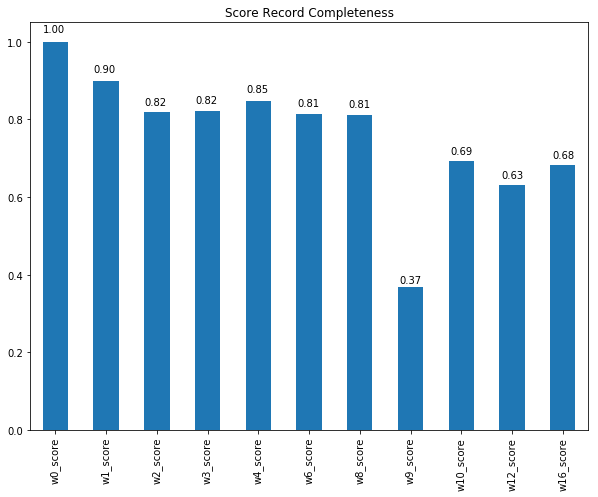

In [5]:
ax = (data[score_cols].count()/data.shape[0]).plot(kind='bar', title='Score Record Completeness', figsize=(10,7.5))
for p in ax.patches:
    ax.annotate(str(format(p.get_height(), '.2f')), (p.get_x() * 1.005, p.get_height() * 1.025))

Next let's plot the distribution of row completeness with respect to w0 to w8 scores.  For example, how many rows have data for all 7 of the trials.

In [6]:
first_trial_scores = score_cols[:7]  # w0 to w8
data['valid_scores'] = data[first_trial_scores].notnull().sum(axis=1)

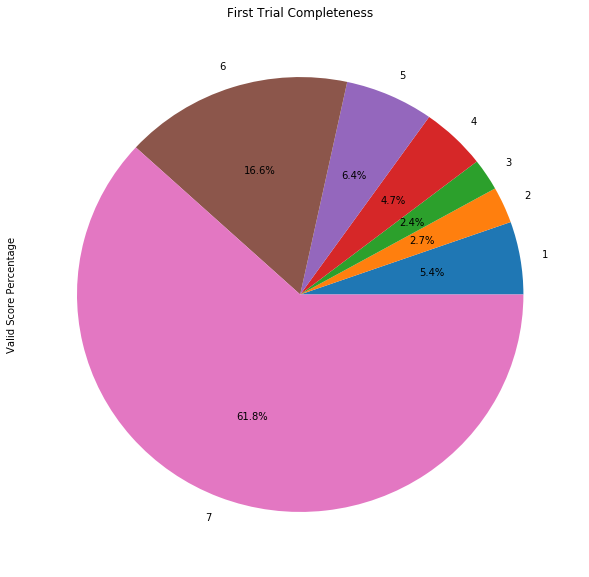

In [7]:
pd.Series(data.groupby(['valid_scores']).size()/data.shape[0], name="Valid Score Percentage").plot(kind='pie', autopct='%1.1f%%', title='First Trial Completeness', figsize=(10,10))

## Score Distributions

Next we will investigate the distribution of scores over each scoring period with respect to the entire dataset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ff2cad0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1103c3950>]], dtype=object)

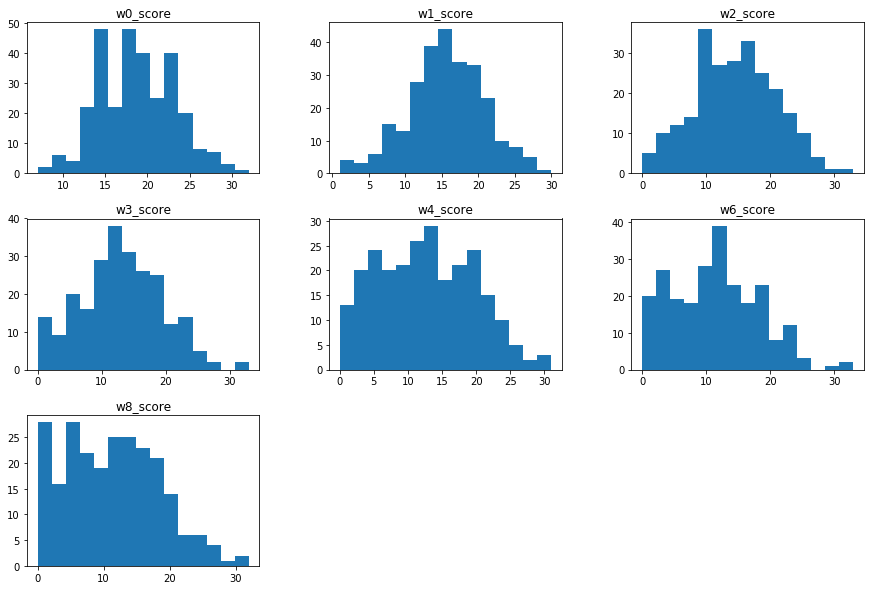

In [8]:
data.hist(column=first_trial_scores, grid=False, figsize=(15,10), bins=15)

The histograms above align with our prior beliefs about the domain.  As the weeks progress we see a shift in the distributions towards a right skewed shape.  This shows that many of the patients are in remission.

### Population Score Distribution

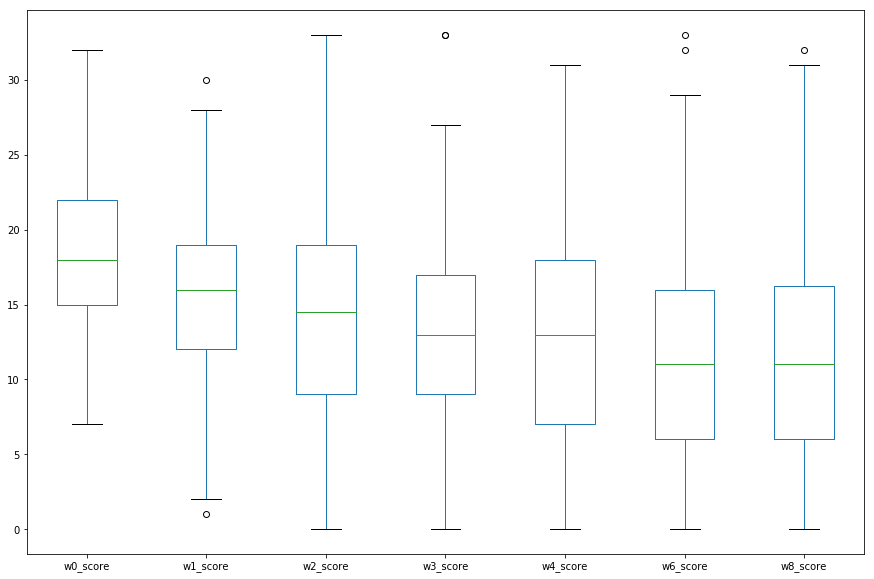

In [9]:
data.boxplot(column=first_trial_scores, grid=False, figsize=(15,10))

At this point we should investigate the distributions conditioned on the class label (effective vs. ineffective).  We will use the assumption that a Hamilton score of $\leq 10$ on week 8 indicates that the treatment was effective.  Effective treatment will be labeled 1, ineffective treatment 0.

In [15]:
data['label'] = data.apply(lambda row: 1 if row.w8_score <= 10 else 0, axis=1)

### Effective Treatment Score Distribution

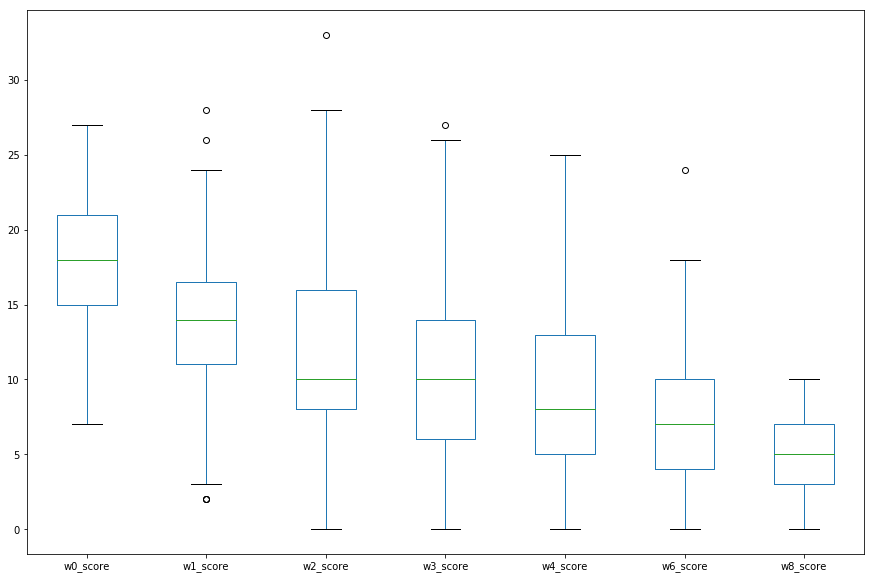

In [19]:
data.loc[data['label'] == 1].boxplot(column=first_trial_scores, grid=False, figsize=(15,10))

### Ineffective Treatment Score Distribution

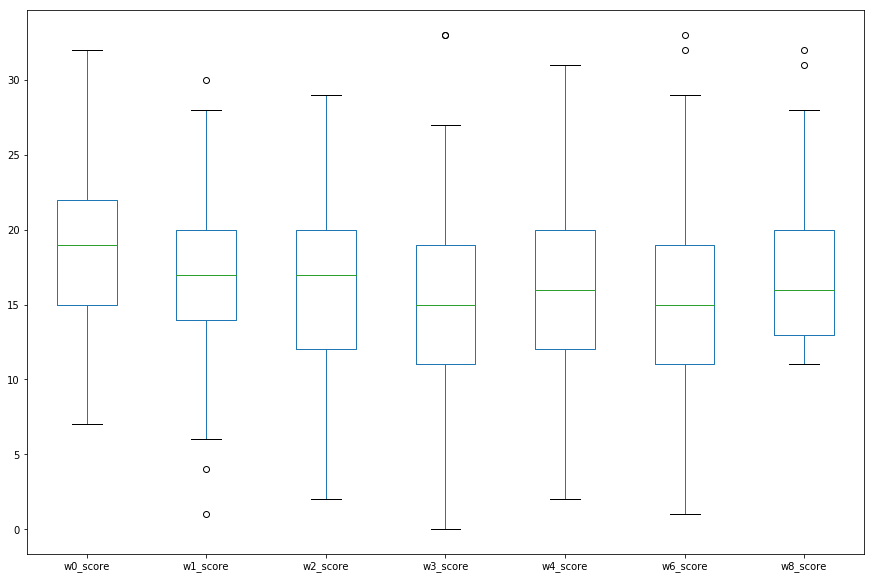

In [20]:
data.loc[data['label'] == 0].boxplot(column=first_trial_scores, grid=False, figsize=(15,10))

It seems clear that there is a difference in the distributions over time conditioned on the effectiveness of the treatment.  When the treatment is effective we see a steady decrease in the median Hamilton score.  Ineffective cases have median fluctuation which is likely attributed to noise.